In [25]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
METRICS_DIR = "../processing/disease_detection/metrics"

In [27]:
def drop_invariant(df):
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    df = df.drop(cols_to_drop, axis=1)
    return df, cols_to_drop

In [28]:
dfs = {}
df = pd.DataFrame()
cols = set()
for file in os.listdir(METRICS_DIR):
    if file.startswith("final") or os.path.isdir(os.path.join(METRICS_DIR, file)):
        continue
    name = file.split("_")[0]
    single_df = pd.read_csv(os.path.join(METRICS_DIR, file))
    single_df, _ = drop_invariant(single_df)
    recall_col = [col for col in single_df.columns if col.startswith("recall")][0]
    auc_col = [col for col in single_df.columns if col.startswith("auc")][0]
    single_df = single_df.rename(columns={auc_col: "auc", recall_col: "recall"})
    cols.update(single_df.columns)
    dfs[name] = single_df

In [29]:
cols = cols - set(["step", "epoch"])
print(cols)

{'recall', 'loss', 'auc', 'binary_accuracy'}


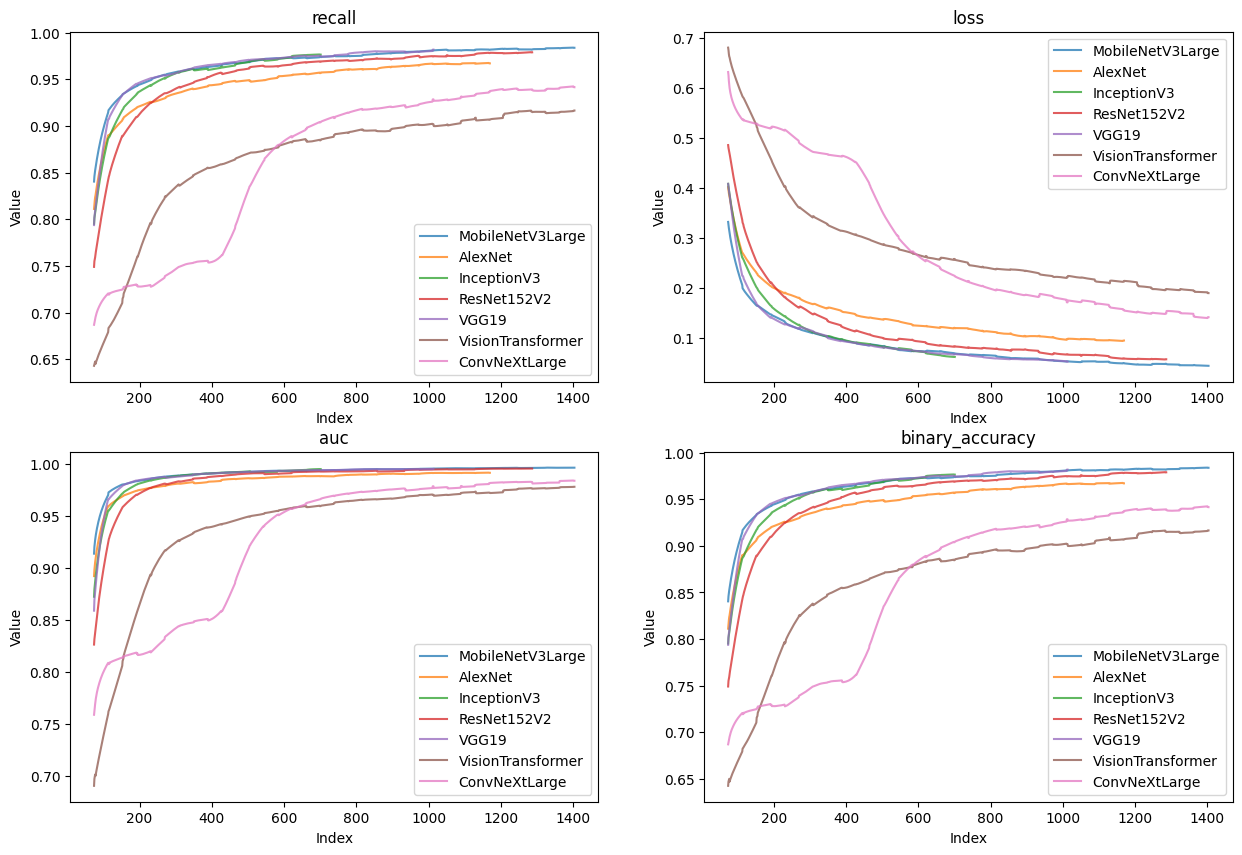

In [34]:
n_cols = len(cols)
n_rows = (n_cols + 1) // 2

window_size = 75

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
axes = axes.flatten()
for i, col in enumerate(cols):
    for name, df in dfs.items():
        if name == "LeNet":
            continue
        axes[i].plot(df[col].rolling(window=window_size).mean(), label=name, alpha=.75)
#        axes[i].plot(df[col], linestyle=(0, (1, 5)), label=name, alpha=.4)
        axes[i].set_title(col)
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Value')
        axes[i].legend()

In [35]:
for name, df in dfs.items():
    for col in cols:
        print(name, col, df[col].min(), df[col].max())

LeNet recall 0.25 0.7017326951026917


KeyError: 'loss'

In [36]:
final_dfs = {}
final_cols = set()
for file in os.listdir(METRICS_DIR):
    if not file.startswith("final"):
        continue
    name = file.split("_")[1]
    df = pd.read_csv(os.path.join(METRICS_DIR, file), index_col="Unnamed: 0")
    df = df.rename(lambda name: re.sub(r'_\d', '', name), axis='columns')
    final_cols.update(df.columns)
    final_dfs[name] = df

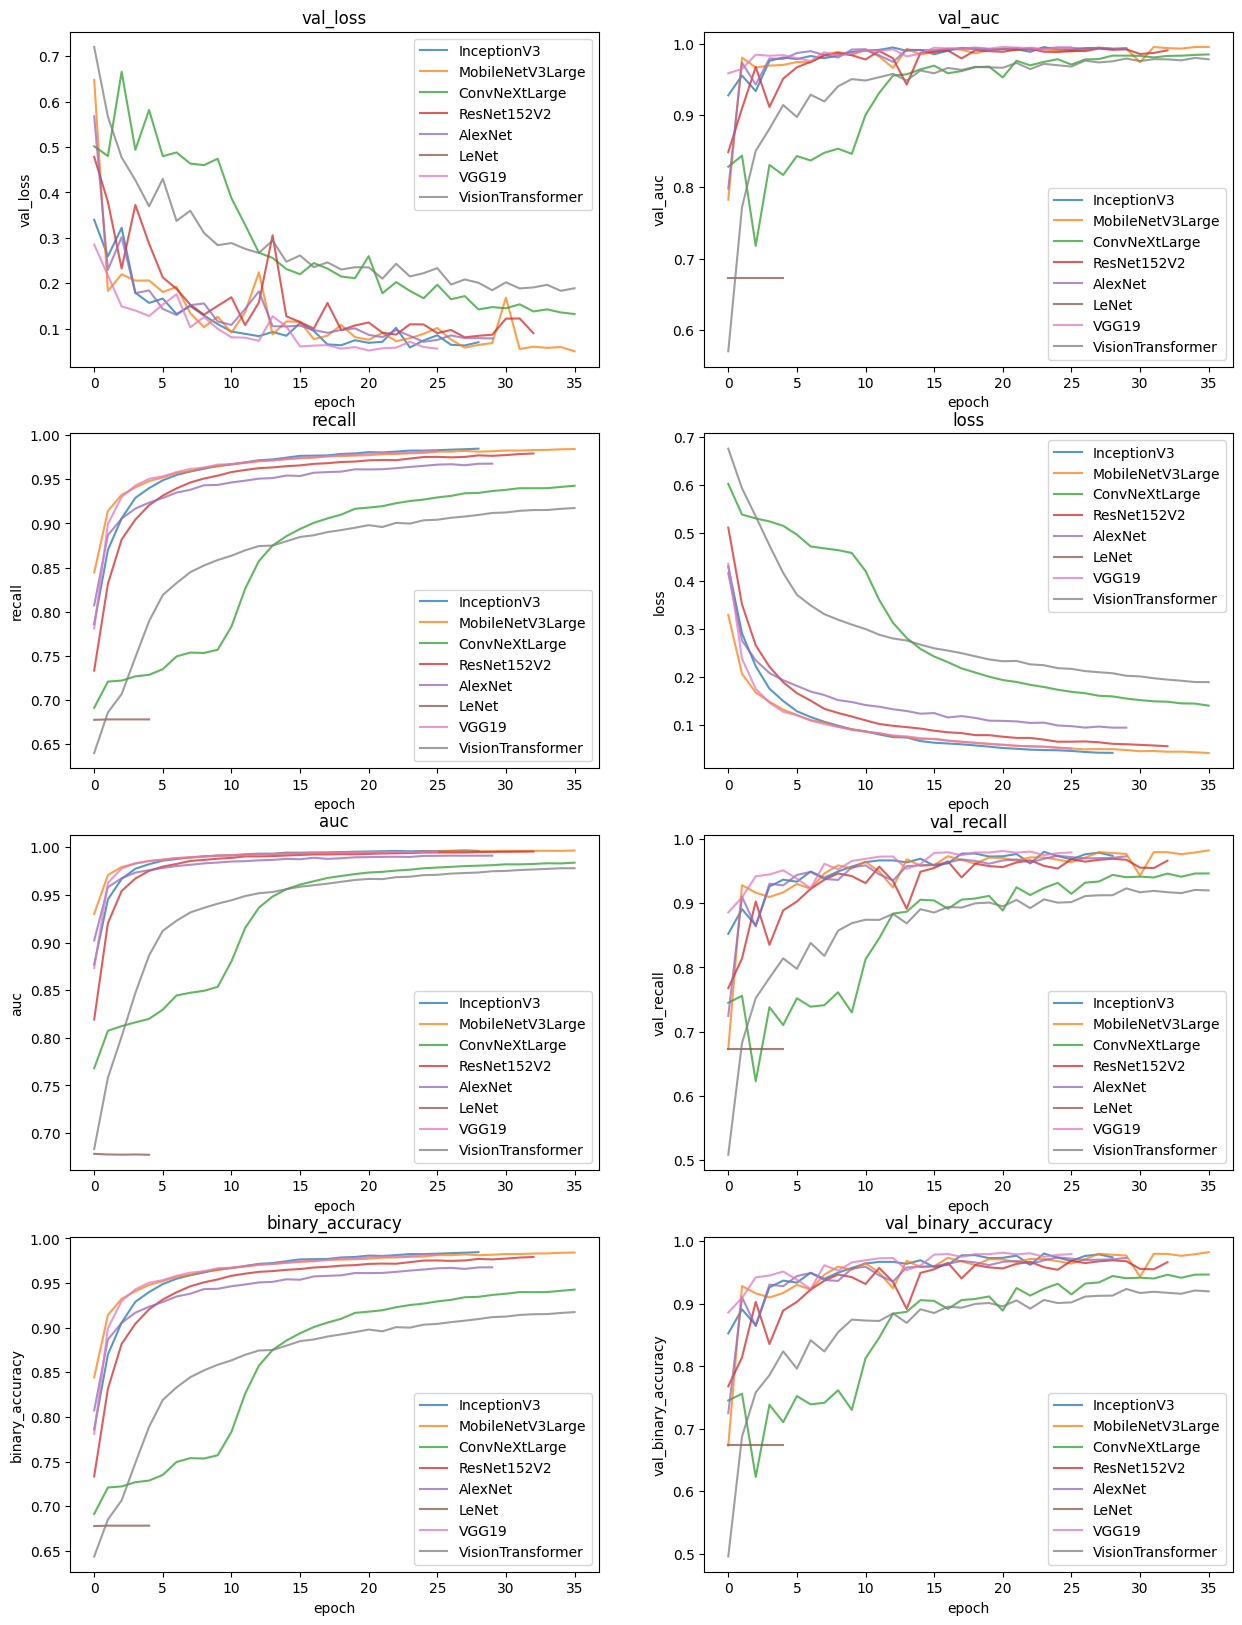

In [39]:
n_cols = len(final_cols)
n_rows = (n_cols + 1) // 2

window_size = 75

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
axes = axes.flatten()
for i, col in enumerate(final_cols):
    for name, df in final_dfs.items():
        line1, = axes[i].plot(df[col], label=name, alpha=.75)
        line2 = axes[i].plot(df[col].rolling(window=5).mean(),
                             linestyle=(0, (3, 3)), 
                             color=line1.get_color(), 
                             label='', 
                             alpha=0)
        axes[i].set_title(col)
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel(col)
        axes[i].legend()